In [5]:
import pandas as pd
import os
from matplotlib import pylab as plt
import numpy as np
from pyteomics import mzml, fasta, parser
from matplotlib_venn import venn2, venn3
from matplotlib.collections import PatchCollection
import matplotlib.patches as mpatches
from scipy.stats import gaussian_kde
import matplotlib.gridspec as gridspec
from scipy.optimize import curve_fit

In [6]:
dot_size = 10
font_on_figure = 8
plt.rcParams.update({'mathtext.default':  'regular' })

In [7]:
# define an object that will be used by the legend
class MulticolorPatch(object):
    def __init__(self, colors):
        self.colors = colors
        
# define a handler for the MulticolorPatch object
class MulticolorPatchHandler(object):
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        width, height = handlebox.width, handlebox.height
        patches = []
        for i, c in enumerate(orig_handle.colors):
            patches.append(plt.Rectangle([width/len(orig_handle.colors) * i - handlebox.xdescent, 
                                          -handlebox.ydescent],
                           width / len(orig_handle.colors),
                           height, 
                           facecolor=c, 
                           edgecolor='black'))

        patch = PatchCollection(patches, match_original=True)
        handlebox.add_artist(patch)
        return patch

## Functions

In [8]:
def get_spectronaut_res(work_dir, inj=None, analysis=None, method=None, sample=None):
    out = []
    for f in os.listdir(work_dir):
        data = {}
        df = pd.read_table(os.path.join(work_dir, f), low_memory=False)
        df.index = df["Parameter"]
        df = df["Value"].to_dict()
        data["file"] = f.split(".")[0]
        data["LC, min"] = float(df["Gradient Length [min]"])
        data["Median FWHM, s"] = round(float(df["Median FWHM"].split(' ')[0])*60, 2)
        data["Data Points per Peak (MS1)"] = float(df["Data Points per Peak (MS1)"].split(' ')[0])
        data["Data Points per Peak (MS2)"] = float(df["Data Points per Peak (MS2)"].split(' ')[0])
        data["Precursors"] =  0 if df["Precursors"].split(" of")[0].replace("\xa0", "")=="NA" else int(df["Precursors"].split(" of")[0].replace("\xa0", ""))
        data["Precursors_all"] = int(df["Precursors"].split(" ")[2].replace("\xa0",""))
        data["PG"] = 0 if df['Protein Groups'].split(" of")[0].replace("\xa0", "")=="NA" else int(df['Protein Groups'].split(" of")[0].replace("\xa0", "")) 
        data["PG_all"] = int(df['Protein Groups'].split(" of")[1].replace("\xa0", ""))
        data["Sample"] = sample
        data["injection"] = inj
        data["analysis"] = analysis
        data["method"] = method
        data["experiment"] = work_dir.split("/")[-3]
        data["path"] = df['Raw File Name']
        out.append(pd.Series(data))
    return  pd.concat(out, axis=1).T

In [9]:
def add_cvs(work_dir):
    """Return CV for MS1 intensities peptide, prot lvl and MS2 int at peptide and prot lvl""" 
    df = pd.DataFrame({})
    pep_file = [x for x in os.listdir(work_dir) if ("Peptides_JB" in x) and x.endswith(".tsv")]
    df_pep = pd.read_table(os.path.join(work_dir, pep_file[0]), low_memory=False)
    df_pep.replace("Filtered", np.nan, inplace=True)
    cols_pep_ms1 = [x for x in df_pep.columns if "PEP.MS1Quantity" in x]
    cols_pep_ms2 = [x for x in df_pep.columns if "PEP.MS2Quantity" in x]
    df_slice = df_pep.loc[:, cols_pep_ms1 + cols_pep_ms2].dropna()
    cv_pep_ms1  = df_slice.loc[:, cols_pep_ms1].astype(float).std(axis=1) / df_slice.loc[:, cols_pep_ms1].astype(float).mean(axis=1) * 100
    cv_pep_ms2  = df_slice.loc[:, cols_pep_ms2].astype(float).std(axis=1) / df_slice.loc[:, cols_pep_ms2].astype(float).mean(axis=1) * 100
    cv_pep_ms1 = cv_pep_ms1.dropna().median()
    cv_pep_ms2 = cv_pep_ms2.dropna().median()

    prot_file = [x for x in os.listdir(work_dir) if ("Protein_JB" in x) and x.endswith(".tsv")]
    df_prot = pd.read_table(os.path.join(work_dir, prot_file[0]), low_memory=False)    
    df_prot["id"] = df_prot["PG.ProteinGroups"].apply(lambda x: x.split(";")[0])
    cols_prot_ms1 = [x for x in df_prot.columns if ".MS1Quantity" in x]
    cols_prot_ms2 = [x for x in df_prot.columns if ".MS2Quantity" in x]
    cv_prot_ms1  = df_prot.loc[:, cols_prot_ms1].std(axis=1) / df_prot.loc[:, cols_prot_ms1].mean(axis=1) * 100
    cv_prot_ms2  = df_prot.loc[:, cols_prot_ms2].std(axis=1) / df_prot.loc[:, cols_prot_ms2].mean(axis=1) * 100
    cv_prot_ms1 = cv_prot_ms1.dropna().median()
    cv_prot_ms2 = cv_prot_ms2.dropna().median()
    return cv_pep_ms1, cv_prot_ms1, cv_pep_ms2 , cv_prot_ms2

In [10]:
def get_experiment_statistics(df):
    experiment = {}
    experiment["experiment"] = "_".join(df.experiment[0].split("_")[2:])
    experiment["LC"] = df["LC, min"][0]
    experiment["Sample"] = df.Sample[0]
    experiment["injection"] = df.injection[0]
    experiment["analysis"] = df.analysis[0]
    experiment["method"] = df.method[0]
    experiment["PG_mean"] = df.PG.mean()
    experiment["PG_std"] = df.PG.std()
    experiment["PG"] = [list(df.PG)]
    experiment["PG_all"] = df.PG_all[0]
    experiment["DPPP_MS1"] = df["Data Points per Peak (MS1)"][0]
    experiment["DPPP_MS2"] = df["Data Points per Peak (MS2)"][0]
    experiment["Precursors_mean"] = df.Precursors.mean()
    experiment["Precursors_std"] = df.Precursors.std()
    experiment["Precursors"] = [list(df.Precursors)]
    experiment["Precursors_all"] = df.Precursors_all[0]
    experiment["FWHM, s"] = df["Median FWHM, s"].mean()
    experiment["folder"] = df.experiment[0]
    experiment["name"] = "\n".join(["_".join([df.Sample[0], df.injection[0]]), df.method[0], df.analysis[0]])  
    experiment["short_name"] =  "_".join([df.injection[0], df.analysis[0]])
    return pd.DataFrame(experiment)

In [11]:
def get_param_table(data, x_param, y_param, inj="any"):
    x_ticks = sorted(data[x_param].unique())
    df = pd.DataFrame(index=x_ticks, columns=data.analysis.unique())
    df = df.apply(lambda x: [])
    data.index = data[x_param]
    if inj == "any":
        for c in data.analysis.unique():
            df[c] = data[(data.analysis == c)][y_param]
    else:
        for c in data.analysis.unique():
            df[c] = data[(data.analysis == c) & (data.injection == inj)][y_param]
    return df

In [12]:
def set_cov_factor(gaus_kde, x_range):
    gaus_kde.covariance_factor = lambda : .25
    gaus_kde._compute_covariance()
    return gaus_kde(x_range)

## load and save data from Spectronaut results

In [13]:
all_data = []

working_dir = "/groups/protechhub/user/Manuel/PRIDE_Uploads/21_AstralPaper/FAIMS_titration/20240209_123837_MM_Astral_paper_FAIMS_CV-38_MBR/"
df = get_spectronaut_res(os.path.join(working_dir, "RunSummaries/"), 
                         inj="250pg", 
                         analysis='MBR',
                         method="20Th_40ms_50SPD", 
                         sample="HeLa")
df_line = get_experiment_statistics(df)
cvs = add_cvs(working_dir)
df_line[["pep_ms1_cv", "prot_ms1_cv", "pep_ms2_cv", "prot_ms2_cv"] ] = cvs
all_data.append(df_line)


working_dir = "/groups/protechhub/user/Manuel/PRIDE_Uploads/21_AstralPaper/FAIMS_titration/20240209_123923_MM_Astral_paper_FAIMS_CV-48_MBR/"
df = get_spectronaut_res(os.path.join(working_dir, "RunSummaries/"), 
                         inj="250pg", 
                         analysis='MBR',
                         method="20Th_40ms_50SPD", 
                         sample="HeLa")
df_line = get_experiment_statistics(df)
cvs = add_cvs(working_dir)
df_line[["pep_ms1_cv", "prot_ms1_cv", "pep_ms2_cv", "prot_ms2_cv"] ] = cvs
all_data.append(df_line)

working_dir = "/groups/protechhub/user/Manuel/PRIDE_Uploads/21_AstralPaper/FAIMS_titration/20240209_123957_MM_Astral_paper_FAIMS_CV-58_MBR/"
df = get_spectronaut_res(os.path.join(working_dir, "RunSummaries/"), 
                         inj="250pg", 
                         analysis='MBR',
                         method="20Th_40ms_50SPD", 
                         sample="HeLa")
df_line = get_experiment_statistics(df)
cvs = add_cvs(working_dir)
df_line[["pep_ms1_cv", "prot_ms1_cv", "pep_ms2_cv", "prot_ms2_cv"] ] = cvs
all_data.append(df_line)


working_dir = "/groups/protechhub/user/Manuel/PRIDE_Uploads/21_AstralPaper/FAIMS_titration/20240209_124032_MM_Astral_paper_FAIMS_CV-68_MBR/"
df = get_spectronaut_res(os.path.join(working_dir, "RunSummaries/"), 
                         inj="250pg", 
                         analysis='MBR',
                         method="20Th_40ms_50SPD", 
                         sample="HeLa")
df_line = get_experiment_statistics(df)
cvs = add_cvs(working_dir)
df_line[["pep_ms1_cv", "prot_ms1_cv", "pep_ms2_cv", "prot_ms2_cv"] ] = cvs
all_data.append(df_line)


working_dir = "/groups/protechhub/user/Manuel/PRIDE_Uploads/21_AstralPaper/FAIMS_titration/20240209_124104_MM_Astral_paper_FAIMS_CV-78_MBR/"
df = get_spectronaut_res(os.path.join(working_dir, "RunSummaries/"), 
                         inj="250pg", 
                         analysis='MBR',
                         method="20Th_40ms_50SPD", 
                         sample="HeLa")
df_line = get_experiment_statistics(df)
cvs = add_cvs(working_dir)
df_line[["pep_ms1_cv", "prot_ms1_cv", "pep_ms2_cv", "prot_ms2_cv"] ] = cvs
all_data.append(df_line)

working_dir = "/groups/protechhub/user/Manuel/PRIDE_Uploads/21_AstralPaper/FAIMS_titration/20240209_124143_MM_Astral_paper_FAIMS_CV-88_MBR/"
df = get_spectronaut_res(os.path.join(working_dir, "RunSummaries/"), 
                         inj="250pg", 
                         analysis='MBR',
                         method="20Th_40ms_50SPD", 
                         sample="HeLa")
df_line = get_experiment_statistics(df)
cvs = add_cvs(working_dir)
df_line[["pep_ms1_cv", "prot_ms1_cv", "pep_ms2_cv", "prot_ms2_cv"] ] = cvs
all_data.append(df_line)

working_dir = "/groups/protechhub/user/Manuel/PRIDE_Uploads/21_AstralPaper/FAIMS_titration/20240209_124255_MM_Astral_paper_no_FAIMS_MBR/"
df = get_spectronaut_res(os.path.join(working_dir, "RunSummaries/"), 
                         inj="250pg", 
                         analysis='MBR',
                         method="20Th_40ms_50SPD", 
                         sample="HeLa")
df_line = get_experiment_statistics(df)
cvs = add_cvs(working_dir)
df_line[["pep_ms1_cv", "prot_ms1_cv", "pep_ms2_cv", "prot_ms2_cv"] ] = cvs
all_data.append(df_line)


In [14]:
data_all = pd.concat(all_data).fillna(0)
data_all.index = data_all.experiment

In [15]:
cols = ['MM_Astral_paper_no_FAIMS_MBR', 'MM_Astral_paper_FAIMS_CV-38_MBR',
       'MM_Astral_paper_FAIMS_CV-48_MBR',
       'MM_Astral_paper_FAIMS_CV-58_MBR',
       'MM_Astral_paper_FAIMS_CV-68_MBR',
       'MM_Astral_paper_FAIMS_CV-78_MBR',
       'MM_Astral_paper_FAIMS_CV-88_MBR',
       ]
data = data_all.loc[cols,:]
data["FAIMS"] = data["experiment"].apply(lambda x: x.split("_")[-2])
data.to_parquet("./serialized_data/fig2/f2_panelabc.parquet", index=False)
data.to_csv("./serialized_data/fig2/f2_panelabc.csv", index=False)

In [16]:
data.columns

Index(['experiment', 'LC', 'Sample', 'injection', 'analysis', 'method',
       'PG_mean', 'PG_std', 'PG', 'PG_all', 'DPPP_MS1', 'DPPP_MS2',
       'Precursors_mean', 'Precursors_std', 'Precursors', 'Precursors_all',
       'FWHM, s', 'folder', 'name', 'short_name', 'pep_ms1_cv', 'prot_ms1_cv',
       'pep_ms2_cv', 'prot_ms2_cv', 'FAIMS'],
      dtype='object')

In [19]:
c = ["method",  "FAIMS", "analysis", "Sample",\
     "experiment", "PG", "PG_mean", "Precursors",
     "Precursors_mean", "prot_ms1_cv", "prot_ms2_cv", 'DPPP_MS1', 'DPPP_MS2', 'FWHM, s']
data.loc[:, c].to_csv("serialized_data/main_f2.csv",sep="\t", index=False)

### for venn diagrams

In [20]:
#peptides
datasets_peptides = dict()
root = "/groups/protechhub/user/Manuel/PRIDE_Uploads/21_AstralPaper/FAIMS_titration/"
for rt, j, files in os.walk(root):
    for file in files:
        if file.endswith("Peptides_JB (Pivot).tsv"):
            df = pd.read_table(os.path.join(rt, file))
            df["peptides"] = df["EG.PrecursorId"].apply(lambda x: x.split("_")[1])
            rep1 = df.columns[4]
            df["counter"]  = 1
            name  = rt.split("_")[-2]  
            datasets_peptides[name] = df.dropna(subset=rep1).drop_duplicates(subset="peptides")
datasets_peptides["noFAIMS"] = datasets_peptides["FAIMS"]

with open("serialized_data/fig2/f2_panelf_pep_nofaims.txt", "w") as f:
    f.write("\n".join(set(datasets_peptides["noFAIMS"]["peptides"])))
with open("serialized_data/fig2/f2_panelf_pep_cv48.txt", "w") as f:
    f.write("\n".join(set(datasets_peptides["CV-48"]["peptides"])))
with open("serialized_data/fig2/f2_panelf_pep_cv58.txt", "w") as f:
    f.write("\n".join(set(datasets_peptides["CV-58"]["peptides"])))

<ipython-input-20-921047a8ab10>:7: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_table(os.path.join(rt, file))
<ipython-input-20-921047a8ab10>:7: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_table(os.path.join(rt, file))
<ipython-input-20-921047a8ab10>:7: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_table(os.path.join(rt, file))
<ipython-input-20-921047a8ab10>:7: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_table(os.path.join(rt, file))


In [21]:
#proteins
datasets_prot = dict()
root = "/groups/protechhub/user/Manuel/PRIDE_Uploads/21_AstralPaper/FAIMS_titration/"
for rt, j, files in os.walk(root):
    for file in files:
        if file.endswith("Protein_JB (Pivot).tsv"):
            print(file)
            df = pd.read_table(os.path.join(rt, file))
            name  = rt.split("_")[-2]  
            datasets_prot[name] = df
datasets_prot["noFAIMS"] = datasets_prot["FAIMS"]  

with open("serialized_data/fig2/f2_panelg_prot_nofaims.txt", "w") as f:
    f.write("\n".join(set(datasets_prot["noFAIMS"]["PG.ProteinGroups"])))
with open("serialized_data/fig2/f2_panelg_prot_cv48.txt", "w") as f:
    f.write("\n".join(set(datasets_prot["CV-48"]["PG.ProteinGroups"])))
with open("serialized_data/fig2/f2_panelg_prot_cv58.txt", "w") as f:
    f.write("\n".join(set(datasets_prot["CV-58"]["PG.ProteinGroups"])))
    

MM_Astral_paper_FAIMS_CV-38_MBR_Report_Protein_JB (Pivot).tsv
MM_Astral_paper_FAIMS_CV-48_MBR_Report_Protein_JB (Pivot).tsv
MM_Astral_paper_FAIMS_CV-58_MBR_Report_Protein_JB (Pivot).tsv
MM_Astral_paper_FAIMS_CV-68_MBR_Report_Protein_JB (Pivot).tsv
MM_Astral_paper_FAIMS_CV-78_MBR_Report_Protein_JB (Pivot).tsv
MM_Astral_paper_FAIMS_CV-88_MBR_Report_Protein_JB (Pivot).tsv
MM_Astral_paper_no_FAIMS_MBR_Report_Protein_JB (Pivot).tsv


### no FAIMS and CV-48 diatributions 

In [57]:
cols_1 = [x for x in datasets_prot["noFAIMS"].columns if "PG.Quantity" in x]
cols_2 = [x for x in datasets_prot["CV-48"].columns if "PG.Quantity" in x]
cols_3 = [x for x in datasets_peptides["noFAIMS"].columns if "PEP.Quantity" in x]
cols_4 = [x for x in datasets_peptides["CV-48"].columns if "PEP.Quantity" in x]
df = pd.concat([pd.Series(datasets_prot["noFAIMS"].loc[:, cols_1[0]][datasets_prot["noFAIMS"].loc[:, cols_1[0]] > 1].values), \
                pd.Series(datasets_prot["CV-48"].loc[:, cols_2[0]][datasets_prot["CV-48"].loc[:, cols_2[0]] > 1].values), \
                pd.Series(datasets_peptides["noFAIMS"].loc[:, cols_3[0]][datasets_peptides["noFAIMS"].loc[:, cols_3[0]] > 1].values), 
                pd.Series(datasets_peptides["CV-48"].loc[:, cols_4[0]][datasets_peptides["CV-48"].loc[:, cols_4[0]] > 1].values)],\
               axis=1)
df.columns = ["nofaims_prot_abund", "cv48_prot_abund", "nofaims_pep_abund", "cv48_pep_abund"]
df.to_csv("./serialized_data/fig2/f2_panelde_noFAIMS_cv48_abund.csv", index=False)

In [58]:
# df.iloc[:20, :]

,nofaims_prot_abund,cv48_prot_abund,nofaims_pep_abund,cv48_pep_abund
0,2265.350098,7068.087891,3683.885254,7068.087891
1,1170.950195,784.548035,2104.377686,1241.415161
2,8742.730469,1470.186646,459.191345,785.310303
3,81.984962,15808.033203,799.643005,101.749557
4,918.247375,519.125549,237.889420,26.055574
5,2695.264160,810.874390,327.934631,1404.964111
6,874.862183,1008.651978,1170.950195,1404.964111
7,613.574524,36.725380,161.822144,16617.636719
8,373.173737,1682.591553,1057.859253,25993.789062
9,4407.697266,2151.777344,1374.220093,6377.339844


In [ ]:
df.iloc[:20, :]

## human + yeast figures

In [15]:
names_dict = {"200pg_50pg_H_Y":"H200_Y50",
              "150pg_100pg_H_Y":"H150_Y100",
              "240pg_10pg_H_Y":"H240_Y10"}
def get_col_name(s):
    first =  "_".join(s.split(".")[0].split("_")[7:])
    first = first.replace( first[:-3], names_dict[first[:-3]])
    last = s.split(".")[-1]
    if last == "MS2Quantity":
        last = "Quantity"
    return "_".join([first, last]) 


### Figure plotting

In [60]:
data = pd.read_parquet("./serialized_data/fig2/f2_panelabc.parquet").set_index("experiment")

In [61]:
#peptides
with open("./serialized_data/fig2/f2_panelf_pep_nofaims.txt", "r") as f:
    nofaims_pep = set(f.read().split("\n"))
with open("./serialized_data/fig2/f2_panelf_pep_cv48.txt", "r") as f:
    cv48_pep = set(f.read().split("\n"))
with open("./serialized_data/fig2/f2_panelf_pep_cv58.txt", "r") as f:
    cv58_pep = set(f.read().split("\n"))
    
#proteins    
with open("./serialized_data/fig2/f2_panelg_prot_nofaims.txt", "r") as f:
    nofaims_prot = set(f.read().split("\n"))
with open("./serialized_data/fig2/f2_panelg_prot_cv48.txt", "r") as f:
    cv48_prot = set(f.read().split("\n"))
with open("./serialized_data/fig2/f2_panelg_prot_cv58.txt", "r") as f:
    cv58_prot = set(f.read().split("\n"))

In [18]:
data_abund = pd.read_csv("./serialized_data/fig2/f2_panelde_noFAIMS_cv48_abund.csv")

In [19]:
W = 0.4
BAR_W = 0.3
colors=[[ "#5f8bd3", "#264d8c", "#1b3764"], ["#d35f8c","#a02c59", "#782143"],  ["#65c4cd", "#3fb5c0", "#32919a", "#1f5b60"],  ["#ffa533", "#ff8e00", "#cc7200", "#995500"]]
  
def plot_panela(ax, data, bar_w=BAR_W, w=W, colors=colors):
    param = "FAIMS"
    inj = "250pg"
    y_param = "PG"
    df = get_param_table(data, param, y_param, inj)
    x = np.arange(df.shape[0]) 
    ax.set_ylabel(y_param, color=colors[0][-1])
    for analysis, c, label in zip(["MBR"], colors[0] , ["DirectDIA"]):
        ax.bar(x, df[analysis].apply(lambda x: np.mean(x)), 
                yerr=df[analysis].apply(lambda x: np.std(x)), 
                color=c, 
                width=bar_w,
                edgecolor=colors[0][-1])  
        for b , yy in zip(x, df[analysis]):
            if not isinstance(yy, list):
                yy = [0] * 3
            xx = np.linspace(b - bar_w / 3, b + bar_w / 3, len(yy))
            ax.scatter(xx, yy, color=c, edgecolors=colors[0][-1], s=dot_size)
        for i, y, in zip(x, df[analysis].fillna(0).apply(lambda x: np.mean(x))):
            if analysis == "MBR":
                t = ax1.annotate(f'{int(y)}', xy=(i, y + 200),  ha='center', color="black",  size=font_on_figure)
            else:
                t = ax1.annotate(f'{int(y)}', xy=(i + 0.05 - 0.015, 200), rotation=90, ha='center', va="bottom", color="white", size=font_on_figure)
    ax.tick_params(axis='y', labelcolor=colors[0][-1])
    ax.set_ylim(2000, 1.5 * max(df["MBR"].dropna().apply(lambda x: np.mean(x))))
    xlabels = [s.replace("FAIMS", "no FAIMS") for s in df.index]
    ax.set_xticks(x + w / 2, xlabels)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(3,3))
    ax.set_xlim(0 - 0.34, len(x) - 1 + 0.4 + w) 
    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    y_param = "Precursors"
    df = get_param_table(data, param, y_param, inj)
    ax2.set_ylabel(y_param, color=colors[1][-1]) 
    for analysis, c, label in zip([ "MBR"], colors[1], ["DirectDIA"]):
        ax2.bar(x + w, df[analysis].apply(lambda x: np.mean(x)),
                yerr=df[analysis].apply(lambda x: np.std(x)),
                color=c, 
                width=bar_w,
            edgecolor=colors[1][-1]) 
        for b , yy in zip(x, df[analysis]):
            if not isinstance(yy, list):
                yy = [0] * len(xx)
            xx = np.linspace(b - bar_w / 3, b + bar_w / 3, len(yy))
            ax2.scatter(xx + w, yy, 
                        color=c, edgecolors=colors[1][-1],
                        s=dot_size)
        for i, y, in zip(x, df[analysis].fillna(0).apply(lambda x: np.mean(x))):
            if analysis == "MBR":
                t = ax2.annotate(f'{int(y)}', xy=(i + w , 2000 + y),  ha='center', color="black", size=font_on_figure)
            else:
                 t = ax2.annotate(f'{int(y)}', xy=(i + w + 0.015, 1000), rotation=90, va="bottom", ha='center', color="white", size=font_on_figure)
    ax2.tick_params(axis='y', labelcolor=colors[1][-1])
    ax2.ticklabel_format(axis='y', style='sci', scilimits=(3,3))
    ax2.set_ylim(0, 1.5 * max(df["MBR"].dropna().apply(lambda x: np.mean(x))))
    xlabels = [s.replace("FAIMS", "no FAIMS") for s in df.index]
    ax2.set_xticks(x + w / 2, xlabels)
    h, l = [], []
    # ------ append the multicolor legend patches
    h.append(MulticolorPatch([colors[0][0], colors[1][0]]))
    l.append("DirectDIA+, with matching")

    # ------ create the legend
    ax1.legend(h, l, loc='upper left', 
             handler_map={MulticolorPatch: MulticolorPatchHandler()}, 
             bbox_to_anchor=(0.5, 0.95))

def plot_panelb(ax, data,bar_w=BAR_W, w=W, colors=colors):
    param = "FAIMS"
    inj = "250pg"
    y_param = "prot_ms1_cv"
    c = colors[2][-1]
    df = get_param_table(data, param, y_param, inj)
    x = np.arange(df.shape[0]) 
    ax.plot(x + w/2, df["MBR"].apply(lambda x: np.median(x)), "-o", color=c,  label = "MS1-based")
    
    y_param = "prot_ms2_cv"
    df = get_param_table(data, param, y_param, inj)
    ax.plot(x + w/2, df["MBR"].apply(lambda x: np.median(x)), "-o", color=colors[2][0], label = "MS2-based")
    ax.set_ylim(5, 25)
    ax.set_ylabel("median CV, %")#, color=c)
    ax.legend(loc="upper center")
    xlabels = [s.replace("FAIMS", "no FAIMS") for s in df.index]
    ax.set_xticks(x + w / 2, xlabels)
    ax.set_xlim(0 - 0.34, len(x) - 1 + 0.4 + w) 
    ax.grid(axis="y")
    
def plot_panelc(ax, data, bar_w=BAR_W, w=W, colors=colors):
    param = "FAIMS"
    inj = "250pg"
    y_param = "DPPP_MS1"
    c = colors[2][-1]
    df = get_param_table(data, param, y_param, inj)
    x = np.arange(df.shape[0]) 
    ax.set_ylabel("points per\n elution peak")#, color=c) 
    ax.plot(x + w / 2, df["MBR"].apply(lambda x: np.median(x)), "-o", color=c,label = "MS1-based")
    
    y_param = "DPPP_MS2"
    df = get_param_table(data, param, y_param, inj)
    ax.plot(x + w/2, df["MBR"].apply(lambda x: np.median(x)), "-o",color=colors[2][0], label = "MS2-based")
    ax.set_ylim(2, 8)
    xlabels = [s.replace("FAIMS", "no FAIMS") for s in df.index]
    ax.set_xticks(x + w / 2, xlabels)
    ax.set_xlim(0 - 0.34, len(x) - 1 + 0.4 + w) 
    ax.grid(axis="y")
    ax.legend(loc="upper right")


In [20]:
def plot_paneld(ax, data_abund, nofaims, cv48, xlabel):    
    ax.scatter(range(len(data_abund[nofaims].dropna())), np.log2(data_abund[nofaims].dropna()).sort_values(), label="no FAIMS")
    ax.scatter(range(len(data_abund[cv48].dropna())), np.log2(data_abund[cv48].dropna()).sort_values(), label="CV-48")
    ax.legend()
    ax.set_ylabel("$log_2(PG\ Abundance)$")
    ax.set_xlabel(xlabel)
    ax.set_ylim(0, 21)

def plot_panele(ax, data_abund, nofaims, cv48):
    ymin = -5
    ymax = 22
    xs = np.linspace(ymin, ymax, 100)
    nofaims_list = data_abund[nofaims].dropna()
    nofaims_list = np.log2(nofaims_list[nofaims_list > 1].sort_values())
    cv48_list = data_abund[cv48].dropna()
    cv48_list = np.log2(cv48_list[cv48_list > 1].sort_values())
    y1_len = len(nofaims_list)
    y2_len = len(cv48_list)
    coef = y2_len/y1_len
    y1 = set_cov_factor(gaussian_kde(nofaims_list), xs)
    y2 = set_cov_factor(gaussian_kde(cv48_list), xs)
    ax.plot(y1, xs)
    ax.plot(coef * y2, xs)
    ax.fill_between(y1, xs, alpha=0.5)
    ax.fill_between(coef * y2, xs, alpha=0.5)
    ax.set_xlabel("Normalized Density")
    ax.set_ylim(0, 21)


In [21]:
def plot_panelhi(ax, nofaims, cv48, cv58):
    v = venn3([nofaims, cv48, cv58], set_labels=["No FAIMS", "CV -48V", "CV -58V"], set_colors=colors, alpha=0.6, ax=ax)
    for i in ["001", "010", "100", "111"]:
        overlap = v.get_patch_by_id(i)
        overlap.set_edgecolor("black")


In [78]:
for i in [nofaims_pep, cv58_pep, cv48_pep]:
    print(len(i))

31798
44234
34262


In [82]:
for i in [nofaims_prot, cv58_prot, cv48_prot]:
    print(len(set(i)& set(cv48_prot)))

3466
5017
5683


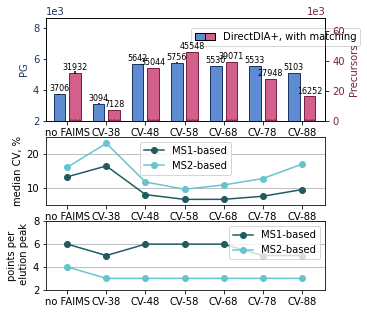

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1 , figsize=(5 , 5),  height_ratios = [3, 2, 2])
plot_panela(ax1, data)
plot_panelb(ax2, data)
plot_panelc(ax3, data)


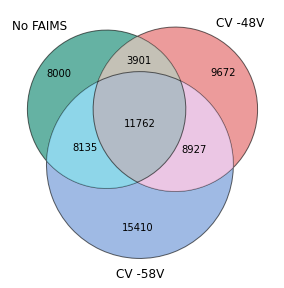

In [23]:
colors = ["#008066", "#e05959", "#5f8dd3"]
fig, (ax1) = plt.subplots(1, 1 , figsize=(5 , 5), )
plot_panelhi(ax1, nofaims_pep, cv48_pep, cv58_pep)

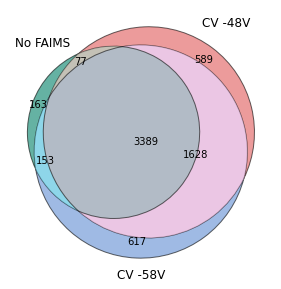

In [24]:
colors = ["#008066", "#e05959", "#5f8dd3"]
fig, (ax1) = plt.subplots(1, 1 , figsize=(5 , 5), )
plot_panelhi(ax1, nofaims_prot, cv48_prot, cv58_prot)

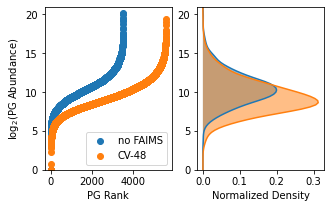

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2 , figsize=(5, 3), )
# nofaims_prot_abund	cv48_prot_abund	nofaims_pep_abund	cv48_pep_abund
plot_paneld(ax1, data_abund, "nofaims_prot_abund", "cv48_prot_abund", "PG Rank")
plot_panele(ax2, data_abund, "nofaims_prot_abund", "cv48_prot_abund")


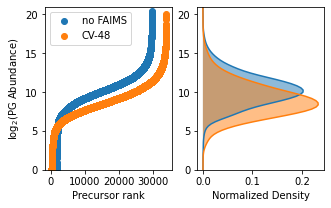

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2 , figsize=(5, 3), )
# nofaims_prot_abund	cv48_prot_abund	nofaims_pep_abund	cv48_pep_abund
plot_paneld(ax1, data_abund, "nofaims_pep_abund", "cv48_pep_abund", "Precursor rank")
plot_panele(ax2, data_abund, "nofaims_pep_abund", "cv48_pep_abund")